In [1]:
#http://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html
#https://gist.githubusercontent.com/Thimira/354b90d59faf8b0d758f74eae3a511e2/raw/fb7cf93aef1c72c24950a10fc71c04065cead3ab/keras_bottleneck_multiclass.py

In [1]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
import cv2  

Using TensorFlow backend.


In [2]:
# dimensions of our images.  
img_width, img_height = 224, 224  

top_model_weights_path = 'bottleneck_fc_model.h5'  
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  

# number of epochs to train top model  
epochs = 100  
# batch size used by flow_from_directory and predict_generator. //Train%%batch_size=0
batch_size = 60   

In [4]:
model = applications.VGG16(include_top=False, weights='imagenet')  


In [5]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    print(len(generator.filenames))
    print(generator.class_indices)
    print(len(generator.class_indices))

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        generator, predict_size_train)

    np.save('bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        generator, predict_size_validation)

    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)


In [6]:
def train_top_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [4]:
def predict():
    # load the class_indices saved in the earlier step
    class_dictionary = np.load('class_indices.npy').item()

    num_classes = len(class_dictionary)

    # add the path to your test image below
    image_path = './data/train/8PSK/7720_8PSK_-6.png'

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    print("Image ID: {}, Label: {}".format(inID, label))

    # display the predictions with the image
    cv2.putText(orig, "Predicted: {}".format(label), (10, 30),
                cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

    cv2.imshow("Classification", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [8]:
save_bottlebeck_features()


Found 6600 images belonging to 11 classes.
6600
{'QPSK': 9, 'AM-DSB': 1, 'AM-SSB': 2, 'PAM4': 6, 'WBFM': 10, 'GFSK': 5, 'CPFSK': 4, 'QAM16': 7, 'QAM64': 8, 'BPSK': 3, '8PSK': 0}
11
Found 6600 images belonging to 11 classes.


Found 6600 images belonging to 11 classes.
Found 6600 images belonging to 11 classes.
Train on 6600 samples, validate on 6600 samples
Epoch 1/100
6600/6600 [==============================] - 13s - loss: 2.4517 - acc: 0.0977 - val_loss: 2.3751 - val_acc: 0.1208
Epoch 2/100
6600/6600 [==============================] - 12s - loss: 2.3497 - acc: 0.1165 - val_loss: 2.2311 - val_acc: 0.1405
Epoch 3/100
6600/6600 [==============================] - 13s - loss: 2.2130 - acc: 0.1402 - val_loss: 2.0951 - val_acc: 0.1665
Epoch 4/100
6600/6600 [==============================] - 13s - loss: 2.1367 - acc: 0.1756 - val_loss: 2.0662 - val_acc: 0.1833
Epoch 5/100
6600/6600 [==============================] - 13s - loss: 2.1021 - acc: 0.1939 - val_loss: 2.0411 - val_acc: 0.2274
Epoch 6/100
6600/6600 [==============================] - 13s - loss: 2.0640 - acc: 0.2195 - val_loss: 1.9847 - val_acc: 0.2632
Epoch 7/100
6600/6600 [==============================] - 13s - loss: 2.0539 - acc: 0.2227 - val_loss: 1.

6600/6600 [==============================] - 13s - loss: 1.8563 - acc: 0.2876 - val_loss: 1.9190 - val_acc: 0.2889
Epoch 65/100
6600/6600 [==============================] - 13s - loss: 1.8731 - acc: 0.2815 - val_loss: 1.8808 - val_acc: 0.2930.28
Epoch 66/100
6600/6600 [==============================] - 13s - loss: 1.8709 - acc: 0.2850 - val_loss: 2.0467 - val_acc: 0.2712
Epoch 67/100
6600/6600 [==============================] - 13s - loss: 1.8635 - acc: 0.2845 - val_loss: 1.9358 - val_acc: 0.2917
Epoch 68/100
6600/6600 [==============================] - 13s - loss: 1.8517 - acc: 0.2906 - val_loss: 1.8691 - val_acc: 0.2971
Epoch 69/100
6600/6600 [==============================] - 13s - loss: 1.8696 - acc: 0.2883 - val_loss: 1.9116 - val_acc: 0.2935
Epoch 70/100
6600/6600 [==============================] - 13s - loss: 1.8493 - acc: 0.2817 - val_loss: 1.9171 - val_acc: 0.2826
Epoch 71/100
6600/6600 [==============================] - 13s - loss: 1.8736 - acc: 0.2850 - val_loss: 1.8826 - va

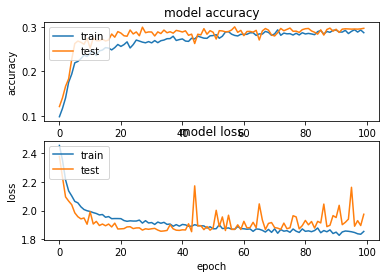

In [9]:
train_top_model()


In [ ]:
predict()

cv2.destroyAllWindows()

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s
Image ID: 2, Label: AM-SSB
